#Deep Learning con Python
`Autor: Erwing FC 
~erwingforerocastro@gmail.com`

###visualizando activaciones intermedias

In [ ]:
#usamos el modelo de dogs vs cats que hemos guardado en el ejercicio anterior
import tensorflow as tf
from google.colab import files
#files.upload() #subimos el modelo
model = tf.keras.models.load_model('network_cats_vs_dogs.h5')
model.summary() 

In [ ]:
from keras.preprocessing import image
import numpy as np

#files.upload() #subimos una imagen de gato
img_path='Wiliams-foto1.jpg' #cambiar por el nombre de la imagen
img=image.load_img(img_path,target_size=(150,150)) #recordar el tamaño usado para las imagenes del modelo
img_tensor=image.img_to_array(img) #150,150,3
img_tensor=np.expand_dims(img_tensor,axis=0) #1,150,150,3
img_tensor/=255 #normalizamos los valores
print(img_tensor.shape)

(1, 150, 150, 3)


<function matplotlib.pyplot.show>

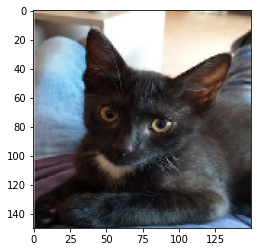

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show

In [ ]:
layer_outputs=[layer.output for layer in model.layers[:8]] #extraemos las salidas de las primeras 8 capas
activation_model=tf.keras.models.Model(inputs=model.input,outputs=layer_outputs) #Crea un modelo que devolverá estas salidas, dada la entrada del modelo

In [ ]:
#realizamos una prediccion
activations=activation_model.predict(img_tensor)
#tomamos la primera capa 
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


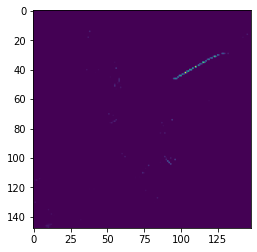

In [ ]:
#tomamos el output de la funcion de activacion 4
plt.imshow(first_layer_activation[0,:,:,4],cmap='viridis')

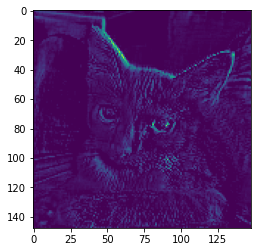

In [ ]:
#tomamos el output de la funcion de activacion 7
plt.imshow(first_layer_activation[0,:,:,7],cmap='viridis')

In [ ]:
layer_names=[layer.name for layer in model.layers[:8]] #los nombres de las capas
images_per_row=16

for layer_name,layer_activation in zip(layer_names,activations):
  n_features=layer_activation.shape[-1]
  size=layer_activation.shape[1]
  
  n_cols=n_features//images_per_row
  display_grid=np.zeros((size*n_cols,images_per_row*size))

  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image=layer_activation[0,:,:,col*images_per_row+row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size,
                   row * size : (row + 1) * size] = channel_image
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
  scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')


###Visualizando los filtros de las covnets

In [16]:
from keras.applications import VGG16
from keras import backend as K
#definiendo el tensor de perdida para el filtro visualizado
model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [17]:
#La llamada a gradientes devuelve una lista de tensores (de tamaño 1 en este caso). Por lo tanto, solo guardas el primer elemento que es un tensor
grads = K.gradients(loss, model.input)[0]
grads

<tf.Tensor 'gradients_2/block1_conv1_8/convolution_grad/Conv2DBackpropInput:0' shape=(None, None, None, 3) dtype=float32>

In [18]:
#truco de normalización 
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) #se agrego 1e-5 para evitar la divicion por 0

In [21]:
#Obteniendo valores de salida de Numpy dados los valores de entrada de Numpy
iterate = K.function([model.input], [loss, grads]) #esta funcion toma un tensor numpy y retorna una lista de dos tensores con la perdida y el gradiente
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))]) 
#loss_values es un escalar
#grads_value un array numpy con un tamaño (1, 150, 150, 3)

(1, 150, 150, 3)

In [22]:
input_img_data=np.random.random((1,150,150,3))*20+128 #imagen en gris aleatoria
step=1 #magnitud de cada actualizacion de la gradiente
#ejecutamos el ascenso del gradiente por 40 pasos
for i in range(40):
  loss_value,grads_value=iterate([input_img_data]) 
  input_img_data+=grads_value*step #ajustamos la entrada de la imagen en la direccion de maximizar la perdida

In [32]:
def deprocess_image(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1
  x += 0.5
  x = np.clip(x, 0, 1)
  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [29]:
def generate_pattern(layer_name,filter_index,size=150):
  layer_output=model.get_layer(layer_name).output
  loss=K.mean(layer_output[:,:,:,filter_index])

  grads = K.gradients(loss, model.input)[0]
  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

  iterate = K.function([model.input], [loss, grads])
  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
  step = 1.
  for i in range(40):
      loss_value, grads_value = iterate([input_img_data])
      input_img_data += grads_value * step
      img = input_img_data[0]
  return deprocess_image(img)

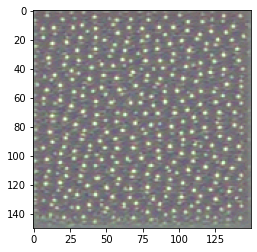

In [33]:
import matplotlib.pyplot as plt

plt.imshow(generate_pattern('block3_conv1', 0))

In [ ]:
layer_name = 'block3_conv1'
size = 64
margin = 5
results = np.zeros((8 * size+7* margin, 8 * size+7* margin, 3))
for i in range(8):
    for j in range(8):
          filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
          horizontal_start = i * size + i * margin
          horizontal_end = horizontal_start + size
          vertical_start = j * size + j * margin
          vertical_end = vertical_start + size
          results[horizontal_start: horizontal_end,
                  vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results)

###Visualizar mapas de calor de activacion de clases

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
from google.colab import files

model = VGG16(weights='imagenet')

files.upload() #subimos la imagen de dos elefantes 
img_path='creative_commons_elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img) #tamaño (224,224,3)
x = np.expand_dims(x, axis=0) #aumentamos a (1,224,224,3)
x = preprocess_input(x)  #preprocesamos la imagen

In [ ]:
preds=model.predict(x)
print('Predicho:', decode_predictions(preds, top=3)[0])
#African elephant (con 84,7% probabilidad)
#Tusker (con 11,7% probabilidad)
#water_buffalo (con 0.4% probabilidad)

In [ ]:
#el indice con mayor probabilidad ('Elefante africano') es 386
np.argmax(preds[0])

In [ ]:
#Grad-CAM algorithm
african_elephant_output = model.output[:, 386] #traemos la salida del modelo
last_conv_layer = model.get_layer('block5_conv3') #traemos la neurona 3 de la capa 5
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0] #traemos el gradiente 

pooled_grads = K.mean(grads, axis=(0, 1, 2)) #hayamos la media
#usamos de nuevo una funcion iterate
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])
#acentuamos los valores 
for i in range(512):
       conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)


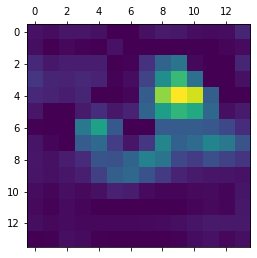

In [43]:
heatmap = np.maximum(heatmap, 0) #traemos los valores maximos despues del 0
heatmap /= np.max(heatmap)       #dividimos heatmap por su maximo valor
plt.matshow(heatmap)

In [ ]:
import cv2
img = cv2.imread(img_path) #cargamos la imagen
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) #aumentamos el tamaño para que sea igual a la original
heatmap = np.uint8(255 * heatmap) #convertir heatmap a RGB
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) #aplicamos el heatmap a la imagen
superimposed_img = heatmap * 0.4 + img  #esta es la intensidad de la heatmap
cv2.imwrite('elephant_cam.jpg', superimposed_img) #guardamos la imagen